In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', None)

from tensorflow.keras.preprocessing import text, sequence
from tensorflow import keras
from keras.utils import np_utils

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [26]:
train_df = pd.read_csv('Corona_NLP_train.csv', 
                       encoding='latin1')
test_df = pd.read_csv('Corona_NLP_test.csv', 
                      encoding='latin1')


In [29]:
train_df.head()


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [31]:
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [37]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [39]:
test_df.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [41]:
X_train, X_val, y_train, y_val = train_test_split(train_df.OriginalTweet.values, train_df.Sentiment.values,
                                                  stratify=train_df.Sentiment.values,
                                                  test_size=.1, shuffle=True, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((37041,), (4116,), (37041,), (4116,))

In [43]:
X_test = test_df.OriginalTweet.values
y_test = test_df.Sentiment.values

In [45]:
text_len = np.array([len(tweet.split(' ')) for tweet in X_train])


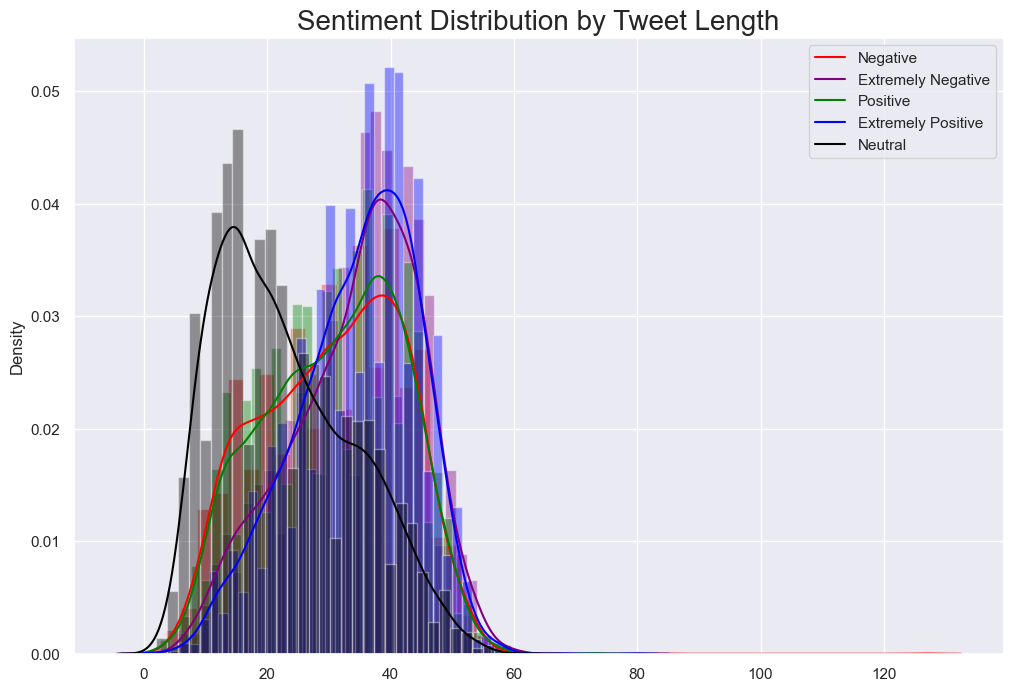

In [47]:
plt.subplots(figsize=(12,8))
sns.distplot(text_len[(y_train == 'Negative')], color='r')
sns.distplot(text_len[(y_train == 'Extremely Negative')], color='purple')
sns.distplot(text_len[(y_train == 'Positive')], color='g')
sns.distplot(text_len[(y_train == 'Extremely Positive')], color='blue')
sns.distplot(text_len[y_train == 'Neutral'], color='black')
plt.legend(['Negative', 'Extremely Negative',
            'Positive', 'Extremely Positive',
            'Neutral'])
plt.title('Sentiment Distribution by Tweet Length', fontsize=20)
plt.show()

In [49]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = str(text).lower()
    text = remove_emoji(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\[', '', text)
    text = re.sub(r'\]', '', text)
    text = re.sub('â\\x92', "'", text)
    text = re.sub('â\S+', '', text)
    text = re.sub('\.+', '.', text)
    text = re.sub('&amp;', 'and', text)
    text = re.sub("let's", 'let us', text)
    text = re.sub("'s", ' is', text)
    text = re.sub("'re", ' are', text)
    text = re.sub("ain't", 'am not', text)
    text = re.sub("won't", 'will not', text)
    text = re.sub("n't", ' not', text)
    text = re.sub("'ve", ' have', text)
    text = re.sub("y'all", "you all", text)
    text = re.sub("'ll", ' will', text)
    text = re.sub("i'd", 'i would', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub(r"[^a-z<>!?\s]+", '', text)
    text = re.sub('covid\S*', 'coronavirus', text)
    text = re.sub('corona\S*', 'coronavirus', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [51]:
X_train_clean = np.array([clean_text(text) for text in X_train], dtype='O')
X_val_clean = np.array([clean_text(text) for text in X_val], dtype='O')
X_test_clean = np.array([clean_text(text) for text in X_test], dtype='O')

In [53]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
tokenizer = nltk.tokenize.TweetTokenizer()
def lemmatize(sentence):
    words = tokenizer.tokenize(sentence)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return words

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/johnnguyen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [55]:
X_train_clean = np.array([lemmatize(text) for text in tqdm(X_train_clean)], dtype='O')
print('LEMMATIZE TRAIN DONE!')
X_val_clean = np.array([lemmatize(text) for text in tqdm(X_val_clean)], dtype='O')
print('LEMMATIZE VAL DONE!')
X_test_clean = np.array([lemmatize(text) for text in tqdm(X_test_clean)], dtype='O')
print('LEMMATIZE TEST DONE!')

100%|████████████████████████████████████| 37041/37041 [00:50<00:00, 727.44it/s]


LEMMATIZE TRAIN DONE!


100%|██████████████████████████████████████| 4116/4116 [00:05<00:00, 737.57it/s]


LEMMATIZE VAL DONE!


100%|██████████████████████████████████████| 3798/3798 [00:05<00:00, 670.32it/s]

LEMMATIZE TEST DONE!


In [58]:
max_len = max([len(sent) for sent in X_train_clean])
max_len

151

In [59]:
model_tokenizer = text.Tokenizer(filters=None, oov_token='<OOV>')
model_tokenizer.fit_on_texts(list(X_train_clean) + list(X_val_clean))
X_train_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_train_clean),
                                       maxlen=max_len, padding='post')
X_val_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_val_clean),
                                       maxlen=max_len, padding='post')
X_test_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_test_clean),
                                       maxlen=max_len, padding='post')

word_index = model_tokenizer.word_index

In [60]:
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in tqdm(word_index.items()):
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector



100%|████████████████████████████████| 42931/42931 [00:00<00:00, 2265946.00it/s]


In [61]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
y_train_onehot = onehot.fit_transform(y_train.reshape(-1,1)).toarray()
y_val_onehot = onehot.transform(y_val.reshape(-1,1)).toarray()
y_test_onehot = onehot.transform(y_test.reshape(-1,1)).toarray()

In [63]:
y_train_3, y_val_3, y_test_3 = y_train.copy(), y_val.copy(), y_test.copy()

y_train_3[y_train_3 == 'Extremely Positive'] = 'Positive'
y_train_3[y_train_3 == 'Extremely Negative'] = 'Negative'
y_val_3[y_val_3 == 'Extremely Positive'] = 'Positive'
y_val_3[y_val_3 == 'Extremely Negative'] = 'Negative'
y_test_3[y_test_3 == 'Extremely Positive'] = 'Positive'
y_test_3[y_test_3 == 'Extremely Negative'] = 'Negative'

In [64]:
onehot_3 = OneHotEncoder()

y_train_3_onehot = onehot_3.fit_transform(y_train_3.reshape(-1,1)).toarray()
y_val_3_onehot = onehot_3.transform(y_val_3.reshape(-1,1)).toarray()
y_test_3_onehot = onehot_3.transform(y_test_3.reshape(-1,1)).toarray()

y_train_3_onehot

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [65]:
model_3 = keras.models.Sequential([
    keras.layers.Embedding(len(word_index)+1,
                           200,
                           input_length=max_len,
                           weights=[embedding_matrix],
                           trainable=False),
    keras.layers.SpatialDropout1D(.5),
    keras.layers.Bidirectional(keras.layers.LSTM(100, recurrent_dropout=.3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(.6),
    
    keras.layers.Dense(3, activation='softmax')
])

model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=.01),
              loss='categorical_crossentropy',
              metrics='accuracy')

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 151, 200)          8586400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 151, 200)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              240800    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                        

In [66]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1,
                                   restore_best_weights=True, verbose=1)

history = model_3.fit(X_train_ready, y_train_3_onehot, validation_data=(X_val_ready, y_val_3_onehot),
                      epochs=10, batch_size=512, callbacks=[es])

Epoch 1/10


2023-03-24 14:48:04.875139: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
  0%|                                                 | 0/37041 [02:02<?, ?it/s]


73/73 [==============================] - 72s 962ms/step - loss: 1.0538 - accuracy: 0.4264 - val_loss: 1.0431 - val_accuracy: 0.4385
Epoch 2/10
73/73 [==============================] - 95s 1s/step - loss: 1.0469 - accuracy: 0.4317 - val_loss: 1.0433 - val_accuracy: 0.4385
Epoch 2: early stopping


In [67]:
model_3.layers[0].trainable = True
model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
                loss='categorical_crossentropy',
                metrics='accuracy')

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 151, 200)          8586400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 151, 200)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              240800    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                        

In [68]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                   restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1,
                                              factor=.1)

history = model_3.fit(X_train_ready, y_train_3_onehot, validation_data=(X_val_ready, y_val_3_onehot),
                      epochs=90, batch_size=512, callbacks=[es, reduce_lr])

Epoch 1/90
73/73 [==============================] - 85s 1s/step - loss: 0.7783 - accuracy: 0.6542 - val_loss: 0.9529 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 2/90
73/73 [==============================] - 106s 1s/step - loss: 0.4282 - accuracy: 0.8522 - val_loss: 0.8722 - val_accuracy: 0.6336 - lr: 0.0010
Epoch 3/90
73/73 [==============================] - 116s 2s/step - loss: 0.2866 - accuracy: 0.9078 - val_loss: 0.7465 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 4/90
73/73 [==============================] - 116s 2s/step - loss: 0.2141 - accuracy: 0.9325 - val_loss: 0.6832 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 5/90
73/73 [==============================] - 116s 2s/step - loss: 0.1676 - accuracy: 0.9467 - val_loss: 0.6362 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 6/90
73/73 [==============================] - 116s 2s/step - loss: 0.1355 - accuracy: 0.9570 - val_loss: 0.6731 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 7/90
73/73 [==============================] - 118s 2s/step - loss: 0.11

In [69]:
loss, acc = model_3.evaluate(X_test_ready, y_test_3_onehot)
print(f'Test set Accuracy with 3 Classes: {acc:.3f}')

119/119 [==============================] - 11s 89ms/step - loss: 0.6666 - accuracy: 0.7293
Test set Accuracy with 3 Classes: 0.729


In [70]:
y_pred_3 = model_3.predict(X_test_ready)
y_pred_3 = np.argmax(y_pred_3, axis=1)

119/119 [==============================] - 10s 80ms/step


In [71]:
y_pred_3 = y_pred_3.astype('O')
y_pred_3[y_pred_3 == 0] = onehot_3.categories_[0][0]
y_pred_3[y_pred_3 == 1] = onehot_3.categories_[0][1]
y_pred_3[y_pred_3 == 2] = onehot_3.categories_[0][2]

y_pred_3

array(['Negative', 'Positive', 'Positive', ..., 'Neutral', 'Negative',
       'Positive'], dtype=object)

In [72]:
print(classification_report(y_test_3, y_pred_3))

              precision    recall  f1-score   support

    Negative       0.73      0.79      0.76      1633
     Neutral       0.83      0.26      0.40       619
    Positive       0.71      0.85      0.78      1546

    accuracy                           0.73      3798
   macro avg       0.76      0.64      0.65      3798
weighted avg       0.74      0.73      0.71      3798

